# 東京都の新型コロナウィルス患者の発生をインタラクティブな地図に視覚化

[以前の記事](https://)で東京都における新型ウィルスの患者の発生について市区町村別のデータを取得する具体例について書きました。その際に保存したデータを地図に視覚化してみましょう。

データを場所に結びつける道具としてgeopandasを使います。pandasはデータをExcelのように表形式で処理するモジュールですが、geopandasはそれに地理的な情報を処理する機能を付加したものです。

これはGoogle Colabに標準で装備されていませんので、pipでインストールします。

In [ ]:
!pip install geopandas

まずは作業場所に移動します。先の東京都のデータを保存したGoogle Driveのcoronavirusディレクトリです。
Google Colabで左にあるファイルメニューを使ってGoogle Driveをマウントしてから、下記を実行してください。

In [ ]:
%cd /content/drive/My\ Drive/coronavirus

/content/drive/My Drive/coronavirus


次に東京都の地図データを入手します。地図のデータ形式は[GeoJSON](https://ja.wikipedia.org/wiki/GeoJSON)がメジャーですが、これにはファイルサイズが大きいという欠点があります。一方、GeoJSONの冗長さを除いた形式がTopoJSONです。これらの相互変換プログラムがあることから、情報量は同じなようです。下記の地図データを配布しているサイトでも、ファイルの小さいTopoJSONの利用が推奨されていますので、そちらを取得します。

In [ ]:
!wget https://raw.githubusercontent.com/dataofjapan/land/master/tokyo.topojson

In [ ]:
!ls

tokyo.json  tokyo.topojson


それではgeopandasを利用して地図を描画してみましょう。geopandasはTopoJSONを直接読み込めます。またplot()でmatplotlibによって地図が描画されます。

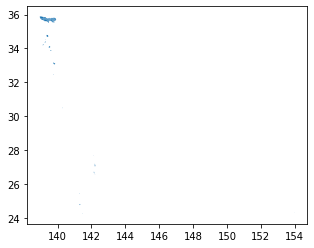

In [ ]:
import geopandas as gpd
tokyo = gpd.read_file('/content/drive/My Drive/coronavirus/tokyo.topojson')
tokyo.plot()

島嶼部まで描画されました。対象から島嶼部を除きましょう。
その前に、そもそもgeopandasはどのようなデータ構造か見てみます。

In [ ]:
tokyo

id ward_ja  ...      code                                           geometry
0   None     足立区  ...  131211.0  POLYGON ((139.84685 35.79629, 139.84506 35.796...
1   None     文京区  ...  131059.0  POLYGON ((139.76084 35.73284, 139.76084 35.731...
2   None    千代田区  ...  131016.0  POLYGON ((139.76980 35.70499, 139.77159 35.704...
3   None     台東区  ...  131067.0  POLYGON ((139.80922 35.72820, 139.80922 35.726...
4   None     品川区  ...  131091.0  MULTIPOLYGON (((139.71962 35.64154, 139.71783 ...
..   ...     ...  ...       ...                                                ...
58  None     大島町  ...  133612.0  MULTIPOLYGON (((139.35945 34.79816, 139.36124 ...
59  None     青梅市  ...  132055.0  POLYGON ((139.33078 35.79320, 139.32899 35.793...
60  None    武蔵野市  ...  132039.0  POLYGON ((139.58702 35.71118, 139.58881 35.711...
61  None   あきる野市  ...  132284.0  POLYGON ((139.16234 35.77772, 139.16413 35.777...
62  None     稲城市  ...  132250.0  MULTIPOLYGON (((139.52072 35.64618, 139.52251 ...

[63 rows x 7 columns]

area_jaが「都区部」あるいは「多摩」のデータだけを残してプロットします。

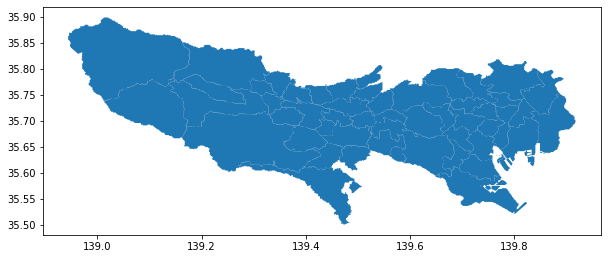

In [ ]:
tokyo = tokyo[[v in ('都区部', '多摩') for v in tokyo['area_ja']]]
tokyo.plot(figsize=(10,10))

ここで東京都の新型コロナ感染者数のデータを読み込みましょう。


In [ ]:
import json
with open('/content/drive/My Drive/coronavirus/tokyo.json') as fin:
    data = json.load(fin)

dataは、以下の構造になっています。
```
[[日付, [[市区町村名, 感染者数], [市区町村名, 感染者数], ...]], ...]
```
次に、市区町村名をキー、感染者数を値とする辞書データをnumという名前で作成します。ここではデータの中でもっとも日付が新しいものから作成します。


In [ ]:
num = {}
for p, n in data[-1][1]:
    num[p] = n

次に、geopandasにnumというカラムを作って、そこに感染者数を格納します。この時、ward_jaに格納されている市区町村名には末尾に市区町村が含まれているのに対し、numのキーにはそれらが含まれていないので、ward_jaのデータから最後の１文字を除いてキーにしているのに注意してください。

In [ ]:
tokyo = tokyo.assign(num = [num[p[:-1]] for p in tokyo['ward_ja']])

plot()に対して、columnで色つけ対象のカラム名を指定し、cmapで色の具合を指定すると、階級区分図が作成できます。便利ですね。

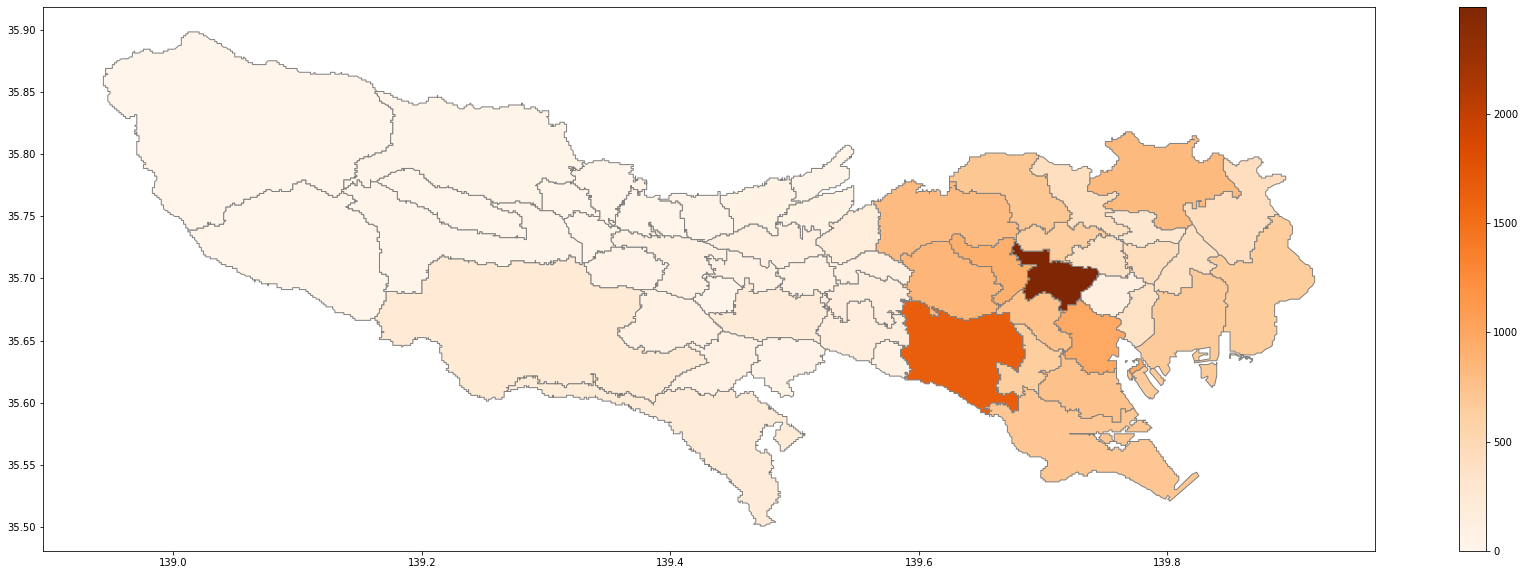

In [ ]:
tokyo.plot(column="num", legend=True, figsize=(30,10), cmap="Oranges", edgecolor='gray')

市区町村名や感染者数の表示も欲しいですね。そのためにはまず、それらを表示する位置を取得してcoordsというカラムに格納します。領域の代表点はrepresentative_point()という関数で算出できます。representative_point()は複数値を返すので最初の点だけにします。

In [ ]:
tokyo = tokyo.assign(coords = tokyo["geometry"].apply(lambda x: x.representative_point().coords[:]))
tokyo = tokyo.assign(coords = [coords[0] for coords in tokyo["coords"]])
tokyo.head()

id ward_ja  ...  num                                   coords
0  None     足立区  ...  817   (139.7944373249135, 35.77849389323932)
1  None     文京区  ...  375   (139.7438155628311, 35.71814196854685)
2  None    千代田区  ...  122  (139.75008728556696, 35.68719226357636)
3  None     台東区  ...  446  (139.78413378041887, 35.71349951280128)
4  None     品川区  ...  758  (139.72948019657767, 35.61291297164716)

[5 rows x 9 columns]

実はこのままでは地図に日本語が表示されません。japanize-matplotlibという便利なモジュールがあるので、インストールします。

In [ ]:
!pip install japanize-matplotlib

matplotlibの機能を使って地図に注釈を表示します。先にplot()で地図を作成してから、plt.annotate()を発行しないと注釈が表示されません。

2020-08-27


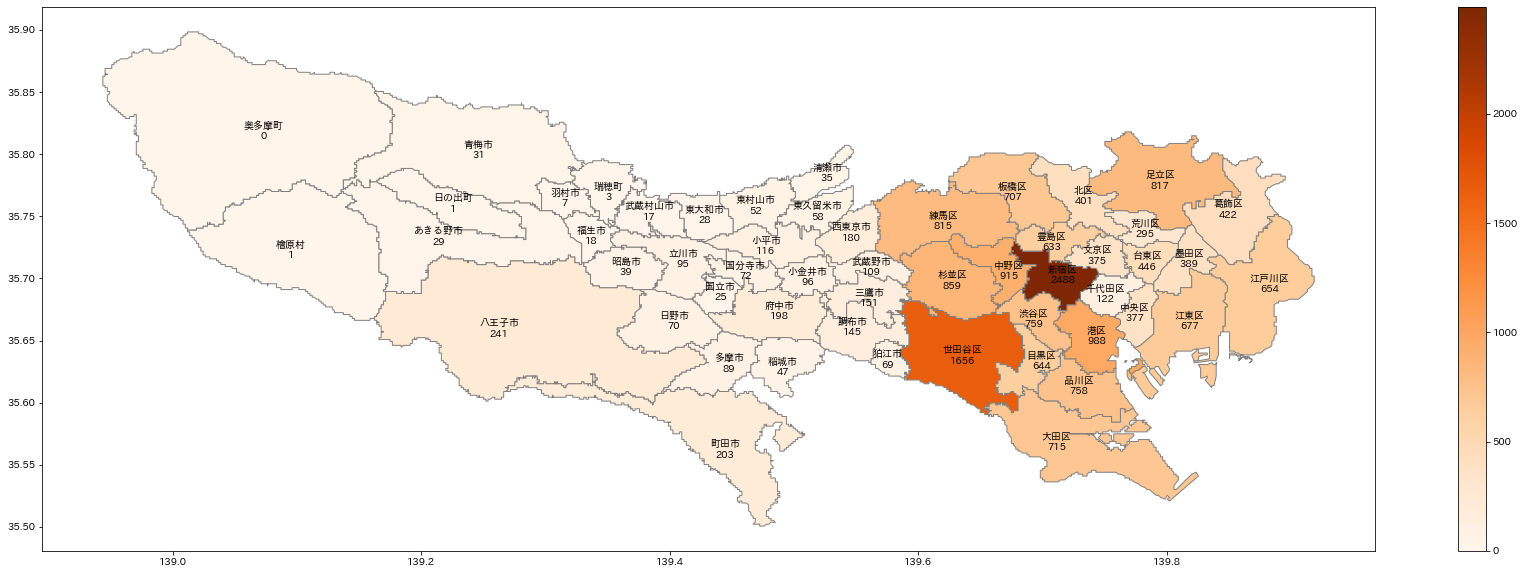

In [ ]:
import matplotlib.pyplot as plt
import japanize_matplotlib
print(data[-1][0][:10])
tokyo.plot(column="num", legend=True, figsize=(30,10), cmap="Oranges", edgecolor='gray')
for i, row in tokyo.iterrows():
    plt.annotate(s='{}\n{}'.format(row["ward_ja"], row['num']), xy=row["coords"], horizontalalignment="center", verticalalignment="center")

次に日々の新規感染者数を表示することを考えましょう。
市区町村ごと前日との差分のリストをincに作ります。incは次の形式になります。
```
[(日付, {市区町村名: 差分, 市区町村名: 差分, ...}), ...]
```

In [ ]:
inc = []
for i, row in enumerate(data[1:], 1):
    d = {}
    for prev, cur in zip(data[i-1][1], row[1]):
        d[cur[0]] = cur[1] - prev[1]
    inc.append((row[0], d))

今回はGoogle ColabのForms機能を利用して、表示するデータを指定するようにしました。ちなみにindex=-1は最後のデータを指定したことになります。また、地図のタイトルに日付が入るようにしました。

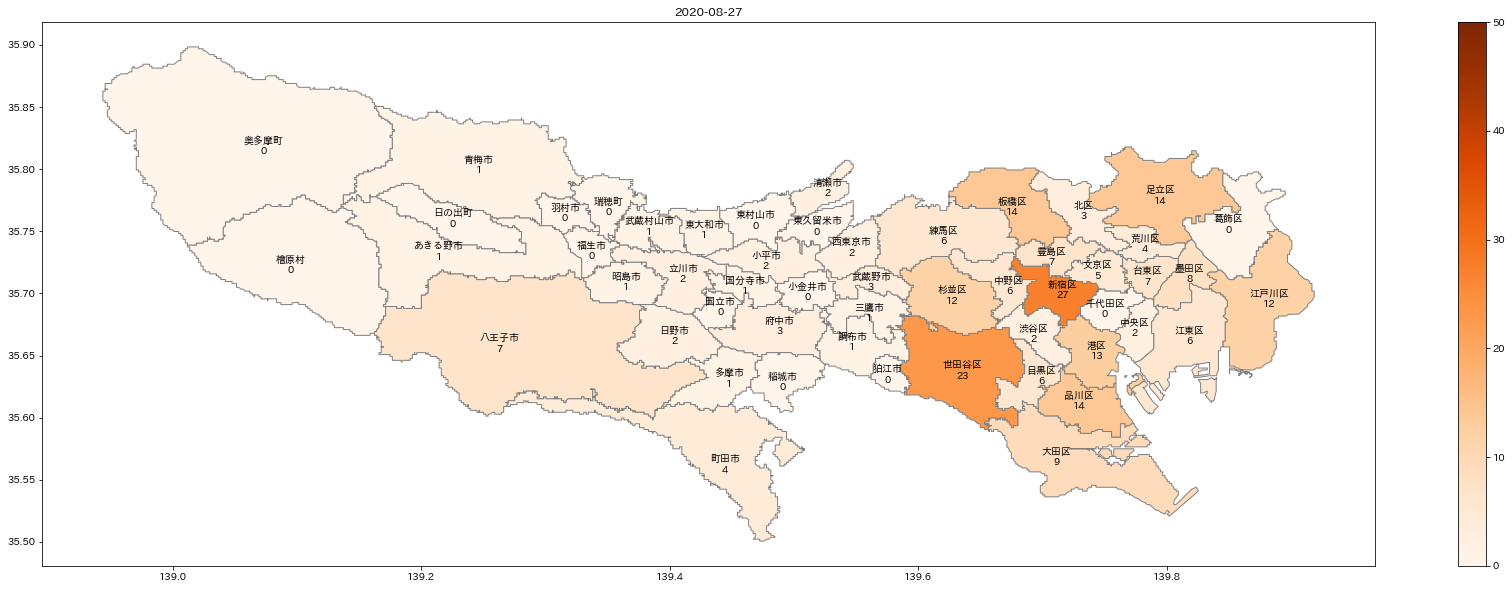

In [ ]:
import matplotlib.pyplot as plt
import japanize_matplotlib

index = -1 #@param {type:"slider", min:-1, max:200, step:1}
tokyo = tokyo.assign(inc = [inc[index][1][p[:-1]] for p in tokyo['ward_ja']])
ax = tokyo.plot(column="inc", legend=True, figsize=[30,10], cmap="Oranges", vmax=50, edgecolor='gray')
ax.set_title(inc[index][0].split(' ')[0])
for i, row in tokyo.iterrows():
    plt.annotate(s='{}\n{}'.format(row["ward_ja"], row['inc']), xy=row["coords"], horizontalalignment="center", verticalalignment="center")

一応できましたが、パラメータを設定して手動で再実行させるのはいまいちです。探してみるとipywidgetsというものがありました。以前はColabで使えなかったようですが、今は一部を除いて使えます。

In [ ]:
from ipywidgets import interact
import matplotlib.pyplot as plt
import japanize_matplotlib

def plot_tokyo(index=0):
    target = tokyo.assign(inc = [inc[index][1][p[:-1]] for p in tokyo['ward_ja']])
    ax = target.plot(column="inc", legend=True, figsize=[30,10], cmap="Oranges", vmax=50, edgecolor='gray')
    ax.set_title(inc[index][0].split(' ')[0])
    for i, row in target.iterrows():
        plt.annotate(s='{}\n{}'.format(row["ward_ja"], row['inc']), xy=row["coords"], horizontalalignment="center", verticalalignment="center")

interact(plot_tokyo, index=(0, len(inc) - 1, 1))

interactive(children=(IntSlider(value=0, description='index', max=148), Output()), _dom_classes=('widget-inter…

<function __main__.plot_tokyo>

スライダーを動かすと追従して図が変化します！すばらしい (注：Colabのランタイムと接続していなければ動きません）

ただ、手でスライダーを動かすのがちょっと煩わしい。自動で動かしたい。実はipywidgetsのPlayがその機能なのですが、Colabではまだ動かないようです。そこで以下のようにスライダーを別立てにして、後からアクセスできるようにします。

In [ ]:
from ipywidgets import IntSlider, interactive_output
slider = IntSlider(min=0, max=len(inc) - 1)
out = interactive_output(plot_tokyo, {'index': slider})
display(slider, out)

IntSlider(value=0, max=148)

Output()

そして以下のようにスライダーの値を変化させると、アニメーションできました。

In [ ]:
import time
for i in range(len(inc)):
    slider.value = i
    time.sleep(0.5)

これを動画にしましょう。まずはimgsディレクトリを作って、その中に各画像を保存します。

In [ ]:
!mkdir -p imgs

from tqdm import tqdm
import matplotlib.pyplot as plt

def save_tokyo(index=0):
    target = tokyo.assign(num = [inc[index][1][p[:-1]] for p in tokyo['ward_ja']])
    ax = target.plot(column="num", legend=True, figsize=[30,10], cmap="Oranges", vmax=50, edgecolor='gray')
    ax.set_title(inc[index][0].split(' ')[0])
    for i, row in target.iterrows():
        plt.annotate(s='{}\n{}'.format(row["ward_ja"], row['num']), xy=row["coords"], horizontalalignment="center", verticalalignment="center")
    plt.savefig('imgs/img.{}.png'.format(index), bbox_inches='tight')
    plt.close()

for index in tqdm(range(len(inc))):
    save_tokyo(index)

次にこれらの画像を元に動画ファイルを生成します。

100%|██████████| 148/148 [00:07<00:00, 19.71it/s]


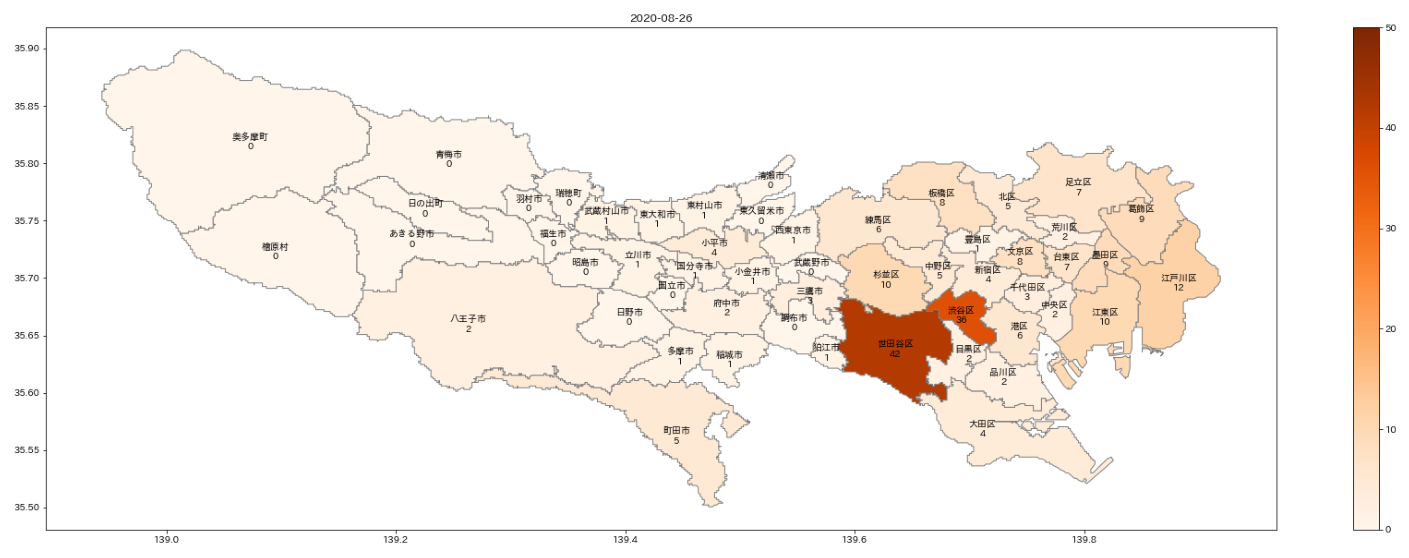

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure(figsize=(30,10))
plt.axis('off')
ims = []
for i in tqdm(range(len(inc)-1)):
    with Image.open('imgs/img.{}.png'.format(i)) as img:
        ims.append([plt.imshow(img)])

ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat=False, blit=True)

ani.save('movie.mp4')
# ani.save('img.gif', writer='pillow')

この動画をGoogle Colabで再生するには以下のようにします。

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('movie.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=1200 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

実はWebの記事の場合、上記の動画以外は動きません。Colabの場合でもランタイムに接続していなければ動きません。上記の動画も、記事上ではColabの出力ではなく動画ファイルへのリンクを貼っているので再生できるのです。ランタイムがなくても動くようにするには、htmlで出力する必要があります。しかし、matplotlibでは動く形でhtmlに出力する機能を見つけられませんでした。

そこでfoliumというモジュールを試してみます。まずは三鷹市を中心にした地図の表示です。三鷹市の緯度経度はgeopyモジュールを用いて取得します。

In [ ]:
import folium
from geopy.geocoders import Nominatim
 
geolocator = Nominatim(user_agent="misc")
 
center_location = list(geolocator.geocode("三鷹市").point)[:2]
map = folium.Map(location=center_location, zoom_start=11)
map.save('tokyo1.html')
map

準備いらずでいきなり地図が表示できました。生成されたtokyo1.htmlをダウンロードしてブラウザで見れば、地図がみられるはずです。上記の図も記事内ではリンクを貼っているので見えているはずです。スクロールや拡大縮小もできますね？



この地図に東京都の市町村境界情報を付与します。foliumにはTopoJSONを直接読み込む機能があるのでそれを利用します。ただ、その際に境界の情報のjson内での位置を指定する必要があります。tokyo.topojsonの内容を確認すると、それが'objects.tokyo'であることがわかるので、folium.TopoJson()の第２引数にそれを指定しました。できた地図はtokyo2.htmlに保存しています。

In [ ]:
import requests
import json

map = folium.Map(location=center_location, zoom_start=11)
topojson = json.loads(requests.get('https://raw.githubusercontent.com/dataofjapan/land/master/tokyo.topojson').text)
folium.TopoJson(topojson, 'objects.tokyo').add_to(map)
map.save('tokyo2.html')
map

階級区分図はChoropleth()で作成できます。引数dataに東京の感染者数を格納したGeoJSONファイルのtokyoを指定しています。このtokyoのnumカラムに感染者数の累計を格納していました。引数columnsに指定するリストは、最初がgeo_dataとの紐付けに使うカラム、２番目が区分図の階級に使うカラムです。ここでは、ward_jaとnumです。またTopoJSONをgeo_dataに指定した場合は、TopoJSON中の境界データの位置と紐付けデータの位置をそれぞれ引数topojsonと引数key_onに指定します。

In [ ]:
map = folium.Map(location=center_location, zoom_start=11)
choropleth = folium.Choropleth(geo_data=topojson, data=tokyo, columns=["ward_ja", 'num'], fill_color='OrRd', topojson='objects.tokyo', key_on='feature.properties.ward_ja')
choropleth.add_to(map)
map.save('tokyo3.html')
map

次に感染者数を地図上に表示してみましょう。foliumではマーカーを配置できますが、そのマーカーにhtmlを指定できるので、その機能を使います。注意点として、緯度経度を指定する順序がGeoJSONと違っているので、修正する必要があります。具体的には
```
folium.Marker(location=coord[::-1], icon=folium.DivIcon('<font color="blue">{}</font>'.format(n))).add_to(map)
```
のcoord[::-1]の部分です。ここで順番を逆にしています。

In [ ]:
map = folium.Map(location=center_location, zoom_start=11)
choropleth = folium.Choropleth(geo_data=topojson, data=tokyo, columns=['ward_ja', 'num'], fill_color='OrRd', topojson='objects.tokyo', key_on='feature.properties.ward_ja')
choropleth.add_to(map)
for coord, n in zip(tokyo['coords'], tokyo['num']):
    folium.Marker(location=coord[::-1], icon=folium.DivIcon('<font color="blue">{}</font>'.format(n))).add_to(map)
map.save('tokyo4.html')
map

foliumにはTimeSliderChoroplethという機能があるので、これで１日あたりの新規患者数の推移を可視化できます。

In [ ]:
import pandas as pd
import numpy as np
import branca.colormap as cm
import datetime

# vmax = max([max(item[1].values()) for item in inc])
linear = cm.LinearColormap(['orange', 'red'], vmin=0, vmax=50).to_step(50)

src = tokyo['geometry'].to_json()
styles = {}
for i in tokyo.index:
    key = tokyo['ward_ja'][i][:-1]
    opacity = np.full(len(inc), 0.6)
    for ii, v in enumerate([row[1][key] for row in inc]):
        if v == 0:
            opacity[ii] = 0
    d = pd.DataFrame(
        {
            'opacity': opacity,
            'color': [linear(v) for v in [row[1][key] for row in inc]]
        },
        index=[int(datetime.datetime.strptime(v[0], '%Y-%m-%d %H:%M:%S').timestamp()) for v in inc]
    )
    styles[i] = d
styledict = {i: v.to_dict(orient='index') for i, v in styles.items()}

In [ ]:
import folium
import folium.plugins

map = folium.Map(location=center_location, zoom_start=11)
folium.plugins.TimeSliderChoropleth(data=src, styledict=styledict).add_to(map)

map.add_child(linear)

map.save('tokyo5.html')
map

残念ながらTimeSliderChoroplethで各数値を地図上に表示する方法はわかりませんでした。

